In [1]:
import torch
import numpy as np
import sys; sys.path.insert(0, '../')
import d2l_utils
%matplotlib inline

In [2]:
torch.__version__               # PyTorch version
# torch.version.cuda              # Corresponding CUDA version
# torch.backends.cudnn.version()  # Corresponding cuDNN version
# torch.cuda.get_device_name(0)   # GPU type

'1.5.0'

In [3]:
torch.manual_seed(0)
# torch.cuda.manual_seed_all(0)

## Differentiation

pytorch 只支持对浮点数进行自动求导

In [4]:
def f(x): return 3 * x ** 2 - 4 * x

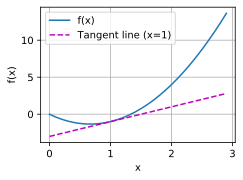

In [5]:
x = np.arange(0, 3, 0.1)
d2l_utils.plot(x, [f(x), 2 * x - 3], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])

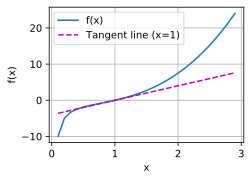

In [6]:
# example 2
def f2(x): return x**3 - 1/x
x = np.arange(0.1, 3, 0.1)
d2l_utils.plot(x, [f2(x), 4*x-4], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])

In [7]:
# 通过 auto_grad 求出在 x=1. 位置的梯度 为 2.
x = torch.tensor(1., requires_grad=True)
fx = f(x)
fx.backward()
x.grad

tensor(2.)

## pytorch 自动求导

- [详解Pytorch 自动微分里的（vector-Jacobian product）](https://zhuanlan.zhihu.com/p/65609544)

In [8]:
# 标量
x = torch.arange(4, dtype=torch.float32, requires_grad=True)
y = (x*x).sum()
y.backward()
x.grad

tensor([0., 2., 4., 6.])

In [9]:
# 非标量 需要传入 gradient 参数, @vector-Jacobian product
x = torch.arange(4, dtype=torch.float32, requires_grad=True)
y = (x*x)
y.backward(torch.ones(4))
x.grad

tensor([0., 2., 4., 6.])

In [10]:
# same as torch.autograd.grad(x*x, x, grad_outputs=torch.ones(4))
x.grad.data.zero_()  # 多次计算梯度会累加, 可以用这样的方法情空
y = (x*x)
y.backward(torch.ones(4))
x.grad

tensor([0., 2., 4., 6.])

In [11]:
# vector-Jacobian product, v = [1.,0.,0.5,1.]
x.grad.data.zero_()  
y = (x*x)
y.backward(torch.tensor([1.,0.,0.5,1.]))
x.grad

tensor([0., 0., 2., 6.])

## 原理 及 计算图说明

Gradient enabled tensors `(variables)` along with functions `(operations)` combine to create the `dynamic computational graph`. The flow of data and the operations applied to the data are defined at runtime hence constructing the computational graph dynamically. This graph is made dynamically by the autograd class under the hood.

`Backward` is the function which actually calculates the gradient by passing it’s argument (1x1 unit tensor by default) through the backward graph all the way up to every leaf node traceable from the calling root tensor. The calculated gradients are then stored in `.grad` of every leaf node. Remember, the backward graph is already made dynamically during the forward pass. Backward function only calculates the gradient using the already made graph and stores them in leaf nodes.

https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95

![image.png](https://tva1.sinaimg.cn/large/007S8ZIlly1ge8kdc6wr7j30r10e5aev.jpg)


In [12]:
# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
y = torch.tensor(2.0)
z = x * y

# Displaying
for i, name in zip([x, y, z], "xyz"):
    print(f"{name}\ndata: {i.data}\nrequires_grad: {i.requires_grad}\n\
grad: {i.grad}\ngrad_fn: {i.grad_fn}\nis_leaf: {i.is_leaf}\n")

x
data: 1.0
requires_grad: True
grad: None
grad_fn: None
is_leaf: True

y
data: 2.0
requires_grad: False
grad: None
grad_fn: None
is_leaf: True

z
data: 2.0
requires_grad: True
grad: None
grad_fn: <MulBackward0 object at 0x12281b490>
is_leaf: False



/Users/ring/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


### vector-jacobian product

- Vector, Matrix, and Tensor Derivatives : http://cs231n.stanford.edu/vecDerivs.pdf

测试 VJP, sigmod(mmul(x, w)) -> softmax-cross-entropy loss

#### 直接用 loss 计算叶结点 w 的 grad

In [13]:
x = torch.randn((3,4))
w = torch.randn((4,5), requires_grad = True)
z = torch.mm(x, w)
a = torch.sigmoid(z)
x, w, z, a

(tensor([[ 1.5410, -0.2934, -2.1788,  0.5684],
         [-1.0845, -1.3986,  0.4033,  0.8380],
         [-0.7193, -0.4033, -0.5966,  0.1820]]),
 tensor([[ 0.4681, -0.1577,  1.4437,  0.2660, -0.1740],
         [-0.6787,  0.9383,  0.4889, -0.6731,  0.8728],
         [ 1.0554,  0.1778, -0.5181, -0.3067, -1.5810],
         [ 1.7066, -0.4462,  0.7440,  1.5210,  3.4105]], requires_grad=True),
 tensor([[-0.4088, -1.1595,  3.6329,  2.1403,  4.8591],
         [ 2.2975, -1.4434, -1.8349,  1.8038,  1.1883],
         [-0.3819, -0.4523, -0.7910,  0.5400,  1.3372]], grad_fn=<MmBackward>),
 tensor([[0.3992, 0.2388, 0.9742, 0.8948, 0.9923],
         [0.9087, 0.1910, 0.1377, 0.8586, 0.7664],
         [0.4057, 0.3888, 0.3120, 0.6318, 0.7920]], grad_fn=<SigmoidBackward>))

In [14]:
target = torch.empty(3, dtype=torch.long).random_(5)
loss = torch.nn.CrossEntropyLoss()
output = loss(a, target)
output.backward(retain_graph=True)
w.grad

tensor([[-0.0008,  0.0499, -0.0104,  0.0435, -0.0282],
        [-0.0193,  0.0550, -0.0121,  0.0079, -0.0245],
        [-0.0302, -0.0422, -0.0095,  0.0242,  0.0011],
        [ 0.0152, -0.0309,  0.0074,  0.0017,  0.0130]])

#### 利用 backward 的 gradient 参数, 分段计算 dL/da, da/dz, dz/dw

In [15]:
loss = torch.nn.CrossEntropyLoss()

# 1
w.grad.zero_()
z = torch.mm(x, w)
# 2
z_hat = z.clone().detach().requires_grad_(True)
a = torch.sigmoid(z_hat)
# 3
a_hat = a.clone().detach().requires_grad_(True)
output = loss(a_hat, target)
output

tensor(1.6362, grad_fn=<NllLossBackward>)

In [16]:
# 计算 dL/da
output.backward(retain_graph=True)
a_hat.grad

tensor([[ 0.0471,  0.0401,  0.0837,  0.0773, -0.2481],
        [ 0.0884, -0.2902,  0.0409,  0.0841,  0.0767],
        [ 0.0593,  0.0583,  0.0540, -0.2590,  0.0873]])

In [17]:
# 计算 dL/da * da/dz (dL/da 作为 backward 的参数 gradient)
a.backward(a_hat.grad, retain_graph=True)
z_hat.grad

tensor([[ 0.0113,  0.0073,  0.0021,  0.0073, -0.0019],
        [ 0.0073, -0.0448,  0.0049,  0.0102,  0.0137],
        [ 0.0143,  0.0139,  0.0116, -0.0602,  0.0144]])

In [18]:
# 计算 dL/da * da/dz * dz/dw
z.backward(z_hat.grad, retain_graph=True)
w.grad

tensor([[-0.0008,  0.0499, -0.0104,  0.0435, -0.0282],
        [-0.0193,  0.0550, -0.0121,  0.0079, -0.0245],
        [-0.0302, -0.0422, -0.0095,  0.0242,  0.0011],
        [ 0.0152, -0.0309,  0.0074,  0.0017,  0.0130]])

#### 分段后, 通过 jvp 计算 dL/dw

In [19]:
a_hat.grad

tensor([[ 0.0471,  0.0401,  0.0837,  0.0773, -0.2481],
        [ 0.0884, -0.2902,  0.0409,  0.0841,  0.0767],
        [ 0.0593,  0.0583,  0.0540, -0.2590,  0.0873]])

In [20]:
"""
z_hat.grad.zero_()
a.sum().backward(retain_graph=True)
z_hat.grad
"""
z_hat.grad.zero_()
a.backward(torch.ones((3, 5)), retain_graph=True)
z_hat.grad

tensor([[0.2398, 0.1818, 0.0251, 0.0942, 0.0076],
        [0.0830, 0.1545, 0.1187, 0.1214, 0.1790],
        [0.2411, 0.2376, 0.2146, 0.2326, 0.1647]])

In [21]:
"""
w.grad.zero_()
z.sum().backward(retain_graph=True)
w.grad
"""
w.grad.zero_()
z.backward(torch.ones((3, 5)), retain_graph=True)
w.grad

tensor([[-0.2628, -0.2628, -0.2628, -0.2628, -0.2628],
        [-2.0954, -2.0954, -2.0954, -2.0954, -2.0954],
        [-2.3721, -2.3721, -2.3721, -2.3721, -2.3721],
        [ 1.5885,  1.5885,  1.5885,  1.5885,  1.5885]])

In [22]:
torch.mm(x.T, a_hat.grad*z_hat.grad)

tensor([[-0.0008,  0.0499, -0.0104,  0.0435, -0.0282],
        [-0.0193,  0.0550, -0.0121,  0.0079, -0.0245],
        [-0.0302, -0.0422, -0.0095,  0.0242,  0.0011],
        [ 0.0152, -0.0309,  0.0074,  0.0017,  0.0130]])

### 另一个例子: 说明向量对矩阵求导, 矩阵对矩阵求导, 及 jvp 在矩阵导数传递中的使用

#### 向量对矩阵求导

y = xW, 维度为  `(1,4) = (1,3) * (3,4)`

我们求 dy/dW = W.grad

In [23]:
x = torch.tensor([[1.,2.,3.]], requires_grad=True)
W = torch.arange(12, dtype=torch.float32).reshape((3, 4)).requires_grad_(True)
x, W

(tensor([[1., 2., 3.]], requires_grad=True),
 tensor([[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]], requires_grad=True))

In [24]:
torch.mm(x, W).sum().backward()
W.grad

tensor([[1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.]])

#### 矩阵对矩阵求导

y = xW, 维度为  `(2,4) = (2,3) * (3,4)`

我们求 dy/dW = W.grad

In [25]:
x = torch.tensor([[1.,2.,3.], [11.,22.,33.]], requires_grad=True)
W = torch.arange(12, dtype=torch.float32).reshape((3, 4)).requires_grad_(True)
x, W

(tensor([[ 1.,  2.,  3.],
         [11., 22., 33.]], requires_grad=True),
 tensor([[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]], requires_grad=True))

In [26]:
torch.mm(x, W).sum().backward()
W.grad

tensor([[12., 12., 12., 12.],
        [24., 24., 24., 24.],
        [36., 36., 36., 36.]])

#### [vector] 比较 backward 直接计算叶结点的 grad

In [27]:
x = torch.tensor([[.1,.2,.3]], requires_grad=True)
W = torch.arange(12, dtype=torch.float32).reshape((3, 4)).requires_grad_(True)
z = torch.mm(x, W) 
#z.retain_grad()  # cal grad for non-leaf variable
a = torch.sigmoid(z)
#a.retain_grad()
x, W, z, a

(tensor([[0.1000, 0.2000, 0.3000]], requires_grad=True),
 tensor([[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]], requires_grad=True),
 tensor([[3.2000, 3.8000, 4.4000, 5.0000]], grad_fn=<MmBackward>),
 tensor([[0.9608, 0.9781, 0.9879, 0.9933]], grad_fn=<SigmoidBackward>))

In [28]:
loss = torch.nn.CrossEntropyLoss()
output = loss(a, torch.tensor([3]))
output.backward(retain_graph=True)
W.grad

tensor([[ 0.0009,  0.0005,  0.0003, -0.0005],
        [ 0.0018,  0.0011,  0.0006, -0.0010],
        [ 0.0028,  0.0016,  0.0009, -0.0015]])

#### [vector] 比较通过 chain rule 的计算

In [29]:
W_ = W.clone().detach().requires_grad_(True)
z = torch.mm(x, W_)
z.sum().backward(retain_graph=True)
W_.grad

tensor([[0.1000, 0.1000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.2000, 0.2000],
        [0.3000, 0.3000, 0.3000, 0.3000]])

In [30]:
z_ = z.clone().detach().requires_grad_(True)
a = torch.sigmoid(z_)
output = loss(a, torch.tensor([3]))
output.backward(retain_graph=True)
z_.grad

tensor([[ 0.0092,  0.0053,  0.0030, -0.0050]])

In [31]:
# W_ = W.clone().detach().requires_grad_(True)
# z = torch.mm(x, W_)
# z.backward(gradient=z_.grad, retain_graph=True)
# W_.grad

In [32]:
x, z_.grad

(tensor([[0.1000, 0.2000, 0.3000]], requires_grad=True),
 tensor([[ 0.0092,  0.0053,  0.0030, -0.0050]]))

In [33]:
torch.mm(x.T, z_.grad)

tensor([[ 0.0009,  0.0005,  0.0003, -0.0005],
        [ 0.0018,  0.0011,  0.0006, -0.0010],
        [ 0.0028,  0.0016,  0.0009, -0.0015]], grad_fn=<MmBackward>)

In [34]:
W_.grad*z_.grad

tensor([[ 0.0009,  0.0005,  0.0003, -0.0005],
        [ 0.0018,  0.0011,  0.0006, -0.0010],
        [ 0.0028,  0.0016,  0.0009, -0.0015]])

#### [matrix] 比较 backward 直接计算叶结点的 grad

In [35]:
x = torch.tensor([[.1,.2,.3],[.11,.22,.33]], requires_grad=True)
W = torch.arange(12, dtype=torch.float32).reshape((3, 4)).requires_grad_(True)
z = torch.mm(x, W) 
a = torch.sigmoid(z)
z, a

(tensor([[3.2000, 3.8000, 4.4000, 5.0000],
         [3.5200, 4.1800, 4.8400, 5.5000]], grad_fn=<MmBackward>),
 tensor([[0.9608, 0.9781, 0.9879, 0.9933],
         [0.9713, 0.9849, 0.9922, 0.9959]], grad_fn=<SigmoidBackward>))

In [36]:
loss = torch.nn.CrossEntropyLoss()
output = loss(a, torch.tensor([1, 3]))
output.backward(retain_graph=True)
W.grad

tensor([[ 8.3968e-04, -5.9931e-04,  2.5861e-04, -8.2454e-05],
        [ 1.6794e-03, -1.1986e-03,  5.1721e-04, -1.6491e-04],
        [ 2.5190e-03, -1.7979e-03,  7.7582e-04, -2.4736e-04]])

#### [matrix] 比较通过 chain rule 的计算

In [37]:
W_ = W.clone().detach().requires_grad_(True)
z = torch.mm(x, W_)
z.sum().backward(retain_graph=True)
W_.grad

tensor([[0.2100, 0.2100, 0.2100, 0.2100],
        [0.4200, 0.4200, 0.4200, 0.4200],
        [0.6300, 0.6300, 0.6300, 0.6300]])

In [38]:
z_ = z.clone().detach().requires_grad_(True)
a = torch.sigmoid(z_)
output = loss(a, torch.tensor([1, 3]))
output.backward(retain_graph=True)
z_.grad

tensor([[ 0.0046, -0.0080,  0.0015,  0.0008],
        [ 0.0034,  0.0019,  0.0010, -0.0015]])

In [39]:
# W_ = W.clone().detach().requires_grad_(True)
# z = torch.mm(x, W_)
# z.backward(gradient=z_.grad, retain_graph=True)
# W_.grad

In [40]:
x, z_.grad

(tensor([[0.1000, 0.2000, 0.3000],
         [0.1100, 0.2200, 0.3300]], requires_grad=True),
 tensor([[ 0.0046, -0.0080,  0.0015,  0.0008],
         [ 0.0034,  0.0019,  0.0010, -0.0015]]))

In [41]:
torch.mm(x.T, z_.grad)

tensor([[ 8.3968e-04, -5.9931e-04,  2.5861e-04, -8.2454e-05],
        [ 1.6794e-03, -1.1986e-03,  5.1721e-04, -1.6491e-04],
        [ 2.5190e-03, -1.7979e-03,  7.7582e-04, -2.4736e-04]],
       grad_fn=<MmBackward>)

In [42]:
torch.set_printoptions(precision=4, sci_mode=True)
print(x[0]*z_.grad[0][0] + x[1]*z_.grad[1][0])
print(x[0]*z_.grad[0][1] + x[1]*z_.grad[1][1])
print(x[0]*z_.grad[0][2] + x[1]*z_.grad[1][2])
print(x[0]*z_.grad[0][3] + x[1]*z_.grad[1][3])
torch.set_printoptions(profile='default')

tensor([8.3968e-04, 1.6794e-03, 2.5190e-03], grad_fn=<AddBackward0>)
tensor([-5.9931e-04, -1.1986e-03, -1.7979e-03], grad_fn=<AddBackward0>)
tensor([2.5861e-04, 5.1721e-04, 7.7582e-04], grad_fn=<AddBackward0>)
tensor([-8.2454e-05, -1.6491e-04, -2.4736e-04], grad_fn=<AddBackward0>)


## torch.no_grad 的使用

Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.

In [43]:
x = torch.tensor([1.], requires_grad=True)
with torch.no_grad():
    y = x * 2
y.requires_grad

False

In [44]:
@torch.no_grad()
def doubler(x):
    return x * 2
z = doubler(x)
z.requires_grad

False

## Numerical gradient checking

> https://pytorch.org/docs/stable/autograd.html#numerical-gradient-checking

In [45]:
a = torch.tensor([[1., -1.], [1., 1.]], requires_grad=True)
torch.autograd.gradcheck(lambda x: x.pow(2).sum(), (a,), eps=1e-3, atol=1e-3)

/Users/ring/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/autograd/gradcheck.py:244: UserWarning: At least one of the inputs that requires gradient is not of double precision floating point. This check will likely fail if all the inputs are not of double precision floating point. 
  'At least one of the inputs that requires gradient '


True